In [18]:
import bisect
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.cross_validation import  train_test_split
from sklearn.metrics import accuracy_score,classification_report,roc_curve
import xgboost as xgb

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [19]:
ip2country = pd.read_csv("https://raw.githubusercontent.com/Thethreebodyproblem/Project-end-to-end/master/IpAddress_to_Country.csv")

In [20]:
ip2country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [21]:
class IpLookupTable(object):
    def __init__(self, df):
        """
        input: 
            df: DataFrame read from 'IpAddress_to_Country.csv'
        """
        self._nrows = df.shape[0]
        # add two more slots, one is for the ipaddress < minimum ipaddress from the file
        # another is for the ipaddress > maximum ipaddress from the file
        self._ip_lowbounds = [0 for _ in range(self._nrows + 2)]
        self._countries = ["Unknown" for _ in range(self._nrows + 2)]

        # start from 1, because 0-th cell is for ipaddress < minimal known ipaddress
        for r in range(1, self._nrows + 1):
            self._ip_lowbounds[r] = df.iloc[r - 1, 0]
            self._countries[r] = df.iloc[r - 1, 2]
            # assume the file is in ascending order
            assert self._ip_lowbounds[r] > self._ip_lowbounds[r - 1]

        # we cannot assign all ip> last low boundary to be that country
        # so I create a dummy ipaddress which larger than maximal known ipaddress
        self._ip_lowbounds[self._nrows + 1] = df.iloc[self._nrows - 1, 1] + 1

    def find_country(self, ip):
        index = bisect.bisect(self._ip_lowbounds, ip) - 1
        # within the range, or in last cell which doesn't have next cell
        assert ip >= self._ip_lowbounds[index] and (index == self._nrows + 1 or ip < self._ip_lowbounds[index + 1])
        return self._countries[index]

In [22]:
iplookuptable = IpLookupTable(ip2country)
iplookuptable

In [23]:
fraud = pd.read_csv("https://raw.githubusercontent.com/Gnishimura/fraud_detection/master/data/Fraud_Data.csv",index_col='user_id')

In [24]:
fraud.head()

,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
user_id,,,,,,,,,,
22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [25]:
import datetime 
fraud["signup_time"]= pd.to_datetime(fraud["signup_time"])
fraud["signup_time"].dt.date

user_id
22058     2015-02-24
333320    2015-06-07
1359      2015-01-01
150084    2015-04-28
221365    2015-07-21
159135    2015-05-21
50116     2015-08-01
360585    2015-04-06
159045    2015-04-21
182338    2015-01-25
199700    2015-07-11
73884     2015-05-29
79203     2015-06-16
299320    2015-03-03
82931     2015-02-16
31383     2015-02-01
78986     2015-05-15
119824    2015-03-20
357386    2015-02-03
289172    2015-07-17
154699    2015-07-08
316355    2015-08-08
343378    2015-01-30
370338    2015-01-08
171711    2015-01-11
59780     2015-01-04
176129    2015-01-28
100886    2015-07-12
221257    2015-05-29
151705    2015-01-07
             ...    
305464    2015-01-07
377130    2015-04-21
364012    2015-04-08
18585     2015-03-31
294702    2015-04-09
227146    2015-03-04
183594    2015-07-13
330979    2015-08-12
82951     2015-05-28
366926    2015-03-15
370144    2015-05-12
25306     2015-05-15
154458    2015-01-06
125907    2015-06-09
27502     2015-04-14
390963    2015-05-20
31855

In [26]:
fraud["country"] = fraud.ip_address.map(iplookuptable.find_country)

In [27]:
print(fraud.head())
print(fraud.shape)

                signup_time        purchase_time  purchase_value  \
user_id                                                            
22058   2015-02-24 22:55:49  2015-04-18 02:47:11              34   
333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
1359    2015-01-01 18:52:44  2015-01-01 18:52:45              15   
150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   

             device_id source browser sex  age    ip_address  class  \
user_id                                                               
22058    QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0   
333320   EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0   
1359     YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1   
150084   ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0   
221365   NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0   

               country  


In [28]:
fraud.loc[fraud.country== "Unknown","ip_address"]

user_id
150084    3.840542e+09
50116     3.987484e+09
73884     4.038285e+09
79203     4.161541e+09
82931     4.203488e+09
119824    1.314238e+05
154699    3.847612e+09
316355    3.836794e+09
107312    3.959167e+09
89475     3.923632e+09
324683    4.228028e+09
336190    4.006900e+09
67592     3.874758e+09
10388     4.132089e+09
50280     4.283641e+09
56338     4.227828e+09
259616    4.060442e+09
322442    4.058504e+09
396395    4.051808e+09
234706    3.774963e+09
147574    4.225495e+09
172444    4.178497e+09
90043     4.084629e+09
75983     3.817746e+09
142279    4.245059e+09
112494    3.775044e+09
126026    4.215622e+09
309021    3.814816e+09
33840     3.828716e+09
321709    4.271865e+09
              ...     
44        4.116284e+09
13111     4.037197e+09
63092     3.842704e+09
306720    3.871485e+09
135861    4.125070e+09
379057    3.778174e+09
60801     4.104768e+09
15872     3.830601e+09
32782     3.895767e+09
213096    3.811422e+09
214530    3.858457e+09
204821    4.059947e+09
259

In [29]:
minip = ip2country.iloc[0,0]
maxip = ip2country.iloc[-1,1]

# check all IP from 'Unknown' country are either < minip or > maxip
country_unknown_ips = fraud.loc[fraud.country == 'Unknown','ip_address']
smaller_than_min = country_unknown_ips < minip
larger_than_max = country_unknown_ips > maxip
assert (np.all( smaller_than_min | larger_than_max))# check succeeds

# Data Cleaning

In [30]:
fraud['signup_time'] = pd.to_datetime(fraud.signup_time)
fraud['purchase_time'] = pd.to_datetime(fraud.purchase_time)
fraud['interval_after_signup'] = (fraud.purchase_time - fraud.signup_time).dt.total_seconds()
fraud.drop(["signup_time", "purchase_time"], axis=1, inplace=True)

In [31]:
fraud.head()

,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,interval_after_signup
user_id,,,,,,,,,,
22058,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0
333320,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0
1359,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0
150084,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown,492085.0
221365,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0


In [32]:
a =fraud.device_id.value_counts()
a =pd.DataFrame(a)
a.loc[:,"name"] =a.index
a.head()

,device_id,name
ZUSVMDEZRBDTX,20,ZUSVMDEZRBDTX
EQYVNEGOFLAWK,20,EQYVNEGOFLAWK
ITUMJCKWEYNDD,20,ITUMJCKWEYNDD
NGQCKIADMZORL,20,NGQCKIADMZORL
CQTUVBYIWWWBC,20,CQTUVBYIWWWBC


In [33]:
fraud =fraud.merge(a, left_on='device_id', right_on='name')

In [34]:
fraud.drop(["device_id_x","device_id_y","name"],axis=1)

,purchase_value,source,browser,sex,age,ip_address,class,country,interval_after_signup
0,34,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0
1,16,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0
2,15,SEO,Opera,M,53,2.621474e+09,1,United States,1.0
3,15,SEO,Opera,M,53,2.621474e+09,1,United States,1.0
4,15,SEO,Opera,M,53,2.621474e+09,1,United States,1.0
5,15,SEO,Opera,M,53,2.621474e+09,1,United States,1.0
6,15,SEO,Opera,M,53,2.621474e+09,1,United States,1.0
7,15,SEO,Opera,M,53,2.621474e+09,1,United States,1.0
8,15,SEO,Opera,M,53,2.621474e+09,1,United States,1.0
9,15,SEO,Opera,M,53,2.621474e+09,0,United States,2552098.0


In [35]:
n_ip_shared = fraud.ip_address.value_counts()

# because we are studying user's first transaction
# the more a ip is shared, the more suspicous
fraud['n_ip_shared'] = fraud.ip_address.map(n_ip_shared)
del fraud['ip_address']

In [36]:
# how many users are from the same country
n_country_shared = fraud.country.value_counts()

# the less visit from a country, the more suspicious
fraud['n_country_shared'] = fraud.country.map(n_country_shared)
del fraud['country']

In [37]:
fraud.head()

,purchase_value,device_id_x,source,browser,sex,age,class,interval_after_signup,device_id_y,name,n_ip_shared,n_country_shared
0,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,0,4506682.0,1,QVPSPJUOCKZAR,1,7918
1,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,0,17944.0,1,EOGFQPIZPYXFZ,1,59222
2,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,1,1.0,12,YSSKYOSJHPPLJ,12,59222
3,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,1,1.0,12,YSSKYOSJHPPLJ,12,59222
4,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,1,1.0,12,YSSKYOSJHPPLJ,12,59222


In [38]:
fraud["sex"] = fraud["sex"].replace({"M":"1", "F":"0"})


In [39]:
del fraud["device_id_x"]


In [40]:
del fraud["name"]

In [41]:
fraud.head()

,purchase_value,source,browser,sex,age,class,interval_after_signup,device_id_y,n_ip_shared,n_country_shared
0,34,SEO,Chrome,1,39,0,4506682.0,1,1,7918
1,16,Ads,Chrome,0,53,0,17944.0,1,1,59222
2,15,SEO,Opera,1,53,1,1.0,12,12,59222
3,15,SEO,Opera,1,53,1,1.0,12,12,59222
4,15,SEO,Opera,1,53,1,1.0,12,12,59222


In [42]:
fraud.columns.values[3] = "Male"

In [43]:
fraud.source = fraud.source.astype("category")
f2dummy= pd.get_dummies(fraud['source'], prefix='source')
fraud1 = pd.concat([fraud, f2dummy],axis=1)
fraud2=fraud1.drop("source",axis=1)
fraud2.browser = fraud.browser.astype("category")
f2dummy1= pd.get_dummies(fraud['browser'], prefix='browser')
fraud3 = pd.concat([fraud2, f2dummy1],axis=1)
fraud4=fraud3.drop("browser",axis=1)


In [44]:
fraud4.Male = fraud4.Male.astype("category")

In [45]:
fraud4.head()

,purchase_value,Male,age,class,interval_after_signup,device_id_y,n_ip_shared,n_country_shared,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari
0,34,1,39,0,4506682.0,1,1,7918,0,0,1,1,0,0,0,0
1,16,0,53,0,17944.0,1,1,59222,1,0,0,1,0,0,0,0
2,15,1,53,1,1.0,12,12,59222,0,0,1,0,0,0,1,0
3,15,1,53,1,1.0,12,12,59222,0,0,1,0,0,0,1,0
4,15,1,53,1,1.0,12,12,59222,0,0,1,0,0,0,1,0


In [46]:
fraud4["class"].value_counts()

0    136961
1     14151
Name: class, dtype: int64

# Modeling

In [47]:
y =fraud4["class"]
X= fraud4.drop(["class"],axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size = 0.20,random_state = 42,stratify= y)

import lightgbm as lgbm
from sklearn.metrics import mean_squared_error
model = lgbm.LGBMClassifier()
model1 = model.fit(X_train, y_train)
y_pred = model1.predict_proba(X_test)

In [48]:
y_pred

array([[0.97136967, 0.02863033],
       [0.9721679 , 0.0278321 ],
       [0.83705835, 0.16294165],
       ...,
       [0.96697618, 0.03302382],
       [0.96823359, 0.03176641],
       [0.97001493, 0.02998507]])

In [49]:
model1.feature_importances_

array([643,  71, 470, 871,  92,  24, 455,  53,  44,  69,  70,  38,  58,
        11,  31])

In [50]:
X.columns

Index(['purchase_value', 'Male', 'age', 'interval_after_signup', 'device_id_y',
       'n_ip_shared', 'n_country_shared', 'source_Ads', 'source_Direct',
       'source_SEO', 'browser_Chrome', 'browser_FireFox', 'browser_IE',
       'browser_Opera', 'browser_Safari'],
      dtype='object')

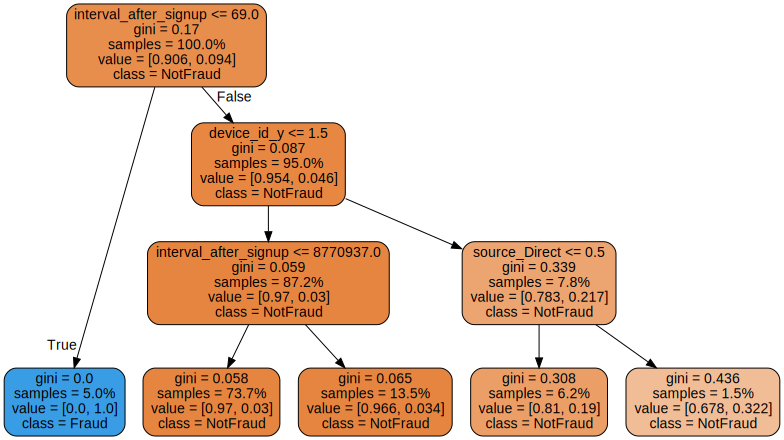

In [68]:
from sklearn import tree
import graphviz
dt = DecisionTreeClassifier(max_depth=3,min_samples_leaf=20,min_samples_split=20)
dt.fit(X,y)
new = export_graphviz(dt,feature_names=X.columns,class_names=['NotFraud','Fraud'],out_file=None,
                proportion=True,leaves_parallel=True,filled=True,rounded=True)
graph = graphviz.Source(new)
graph

dot -Tpng C:\Users\akabo\OneDrive\Desktop\tree.dot -o tree.png

In [61]:
import os
from IPython.display import Image
PROJECT_ROOT_DIR = ""
path_png = os.path.join(PROJECT_ROOT_DIR,"tree.png")
Image(path_png)

TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>